In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

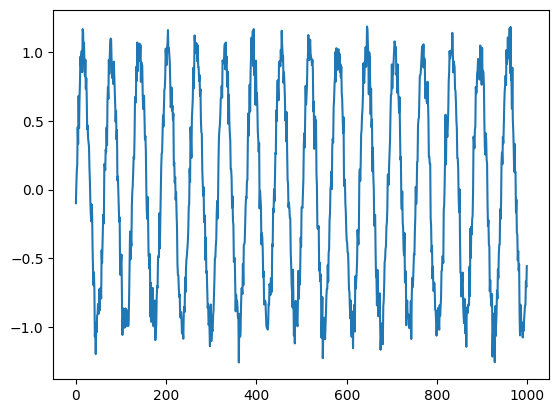

In [2]:
# make the original data
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.1

# plot it
plt.plot(series)
plt.show()

In [3]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [4]:
# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [5]:
### Define simple RNN
# input is N,T,D
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        # note: batch_first=True
        # applies the convention that our data will be of shape:
        # (num_samples, sequence_length, num_features)
        # rather than:
        # (sequence_length, num_samples, num_features)
        self.rnn = nn.RNN(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            nonlinearity='relu',
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those now
        out, _ = self.rnn(X, h0)

        # we only want h(T) at the final time step
        # N x M -> N x K
        out = self.fc(out[:, -1, :])
        return out

In [6]:
# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=15, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [7]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [9]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [10]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=1000):

    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Save losses
        train_losses[it] = loss.item()

        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses


In [11]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/1000, Train Loss: 0.5604, Test Loss: 0.5761
Epoch 10/1000, Train Loss: 0.5450, Test Loss: 0.5606
Epoch 15/1000, Train Loss: 0.5315, Test Loss: 0.5467
Epoch 20/1000, Train Loss: 0.5174, Test Loss: 0.5319
Epoch 25/1000, Train Loss: 0.5022, Test Loss: 0.5157
Epoch 30/1000, Train Loss: 0.4850, Test Loss: 0.4975
Epoch 35/1000, Train Loss: 0.4655, Test Loss: 0.4766
Epoch 40/1000, Train Loss: 0.4421, Test Loss: 0.4513
Epoch 45/1000, Train Loss: 0.4115, Test Loss: 0.4182
Epoch 50/1000, Train Loss: 0.3718, Test Loss: 0.3756
Epoch 55/1000, Train Loss: 0.3244, Test Loss: 0.3261
Epoch 60/1000, Train Loss: 0.2741, Test Loss: 0.2743
Epoch 65/1000, Train Loss: 0.2271, Test Loss: 0.2266
Epoch 70/1000, Train Loss: 0.1838, Test Loss: 0.1818
Epoch 75/1000, Train Loss: 0.1428, Test Loss: 0.1399
Epoch 80/1000, Train Loss: 0.1072, Test Loss: 0.1046
Epoch 85/1000, Train Loss: 0.0794, Test Loss: 0.0772
Epoch 90/1000, Train Loss: 0.0598, Test Loss: 0.0588
Epoch 95/1000, Train Loss: 0.0491, Test Loss: 0

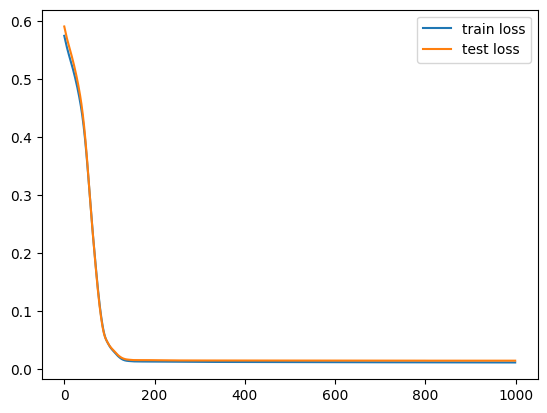

In [12]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [13]:
# "Wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].reshape(1, T, 1)
    p = model(input_)[0,0].item() # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

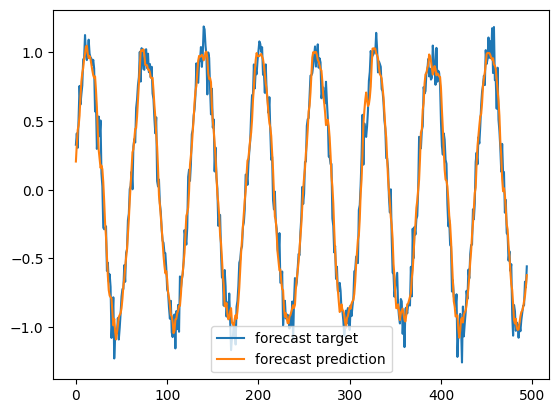

In [14]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [15]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# last_x = torch.from_numpy(X[-N//2]) # 1-D array of length T
# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0,0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

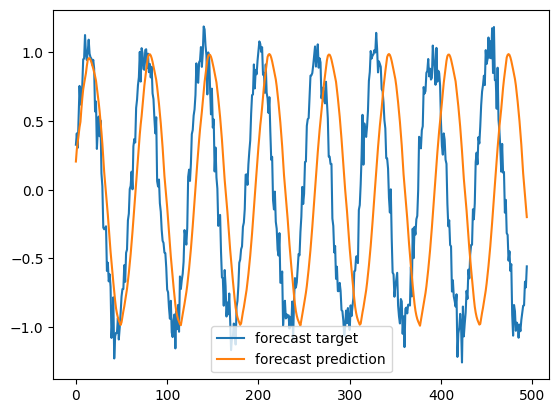

In [16]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()